<a href="https://colab.research.google.com/github/thet-naing-lin/UOR/blob/main/UOR_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

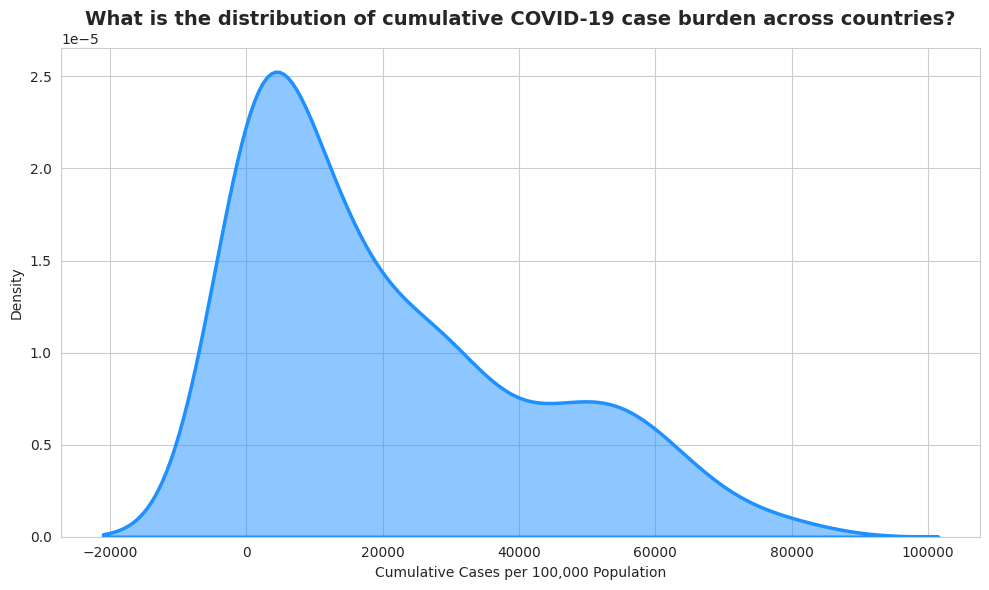

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('WHO-COVID-19-global-table-data.csv')
df.columns = df.columns.str.strip()

# Select relevant column and drop missing/invalid values
df = df[['Name', 'Cases - cumulative total per 100000 population']].copy()
df = df.dropna(subset=['Cases - cumulative total per 100000 population'])
df = df[df['Cases - cumulative total per 100000 population'] > 0]
df = df[df['Name'] != 'Global']  # Remove 'Global' row if present

# Plot density
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.kdeplot(
    df['Cases - cumulative total per 100000 population'],
    color='dodgerblue',
    linewidth=2.5,
    fill=True,
    alpha=0.5
)

plt.title("What is the distribution of cumulative COVID-19 case burden across countries?", fontsize=14, weight='bold')
plt.xlabel("Cumulative Cases per 100,000 Population")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


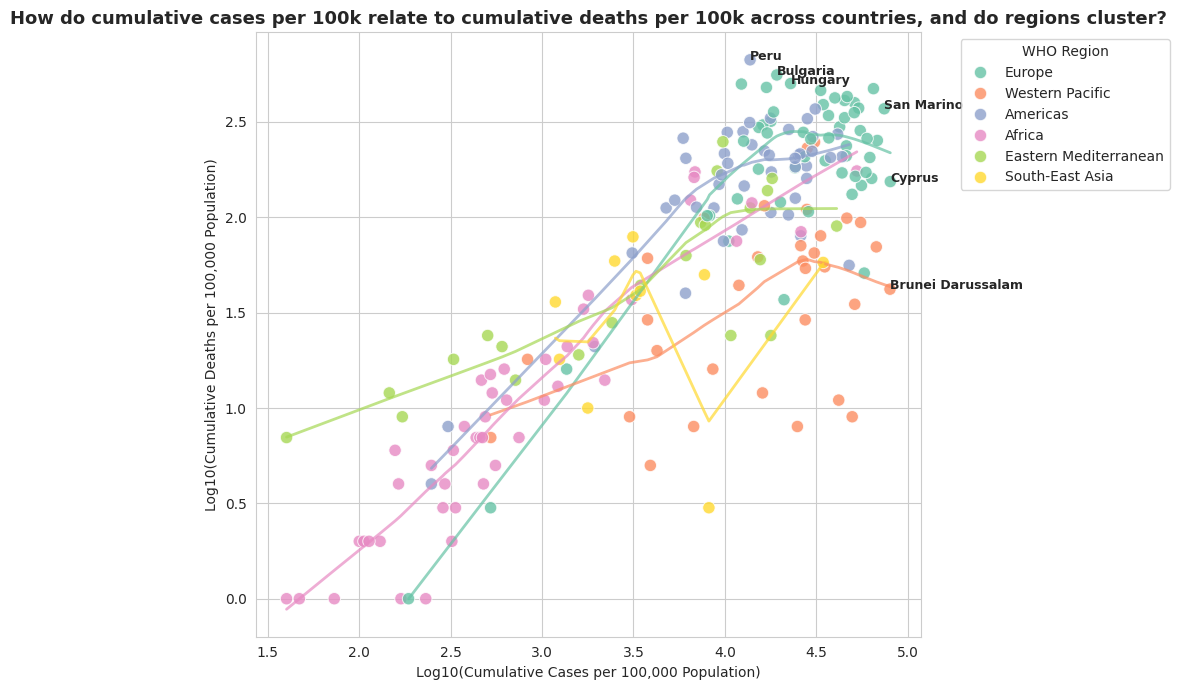

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
df = pd.read_csv('WHO-COVID-19-global-table-data.csv')
df.columns = df.columns.str.strip()

# Select relevant columns and drop missing/zero values
cols = [
    'Name',
    'WHO Region',
    'Cases - cumulative total per 100000 population',
    'Deaths - cumulative total per 100000 population'
]
df = df[cols].dropna()
df = df[
    (df['Cases - cumulative total per 100000 population'] > 0) &
    (df['Deaths - cumulative total per 100000 population'] > 0)
]

# Log-transform the axes for better spread
df['log_cases_per_100k'] = np.log10(df['Cases - cumulative total per 100000 population'])
df['log_deaths_per_100k'] = np.log10(df['Deaths - cumulative total per 100000 population'])

# Set up the plot
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter plot with region coloring
palette = sns.color_palette('Set2', n_colors=df['WHO Region'].nunique())
region_colors = dict(zip(df['WHO Region'].unique(), palette))

scatter = sns.scatterplot(
    data=df,
    x='log_cases_per_100k',
    y='log_deaths_per_100k',
    hue='WHO Region',
    palette=region_colors,
    alpha=0.8,
    edgecolor='w',
    s=80
)

# Add regional LOWESS trend lines
for region, color in region_colors.items():
    region_df = df[df['WHO Region'] == region]
    if len(region_df) > 2:  # LOWESS needs at least 3 points
        sns.regplot(
            data=region_df,
            x='log_cases_per_100k',
            y='log_deaths_per_100k',
            scatter=False,
            lowess=True,
            color=color,
            line_kws={'lw': 2, 'alpha': 0.7, 'label': f"{region} trend"}
        )

# Add axis labels and title
plt.title("How do cumulative cases per 100k relate to cumulative deaths per 100k across countries, and do regions cluster?", fontsize=13, weight='bold')
plt.xlabel("Log10(Cumulative Cases per 100,000 Population)")
plt.ylabel("Log10(Cumulative Deaths per 100,000 Population)")

# Add legend
plt.legend(title="WHO Region", bbox_to_anchor=(1.05, 1), loc='upper left')

# Optionally, annotate top outliers
top_cases = df.sort_values('Cases - cumulative total per 100000 population', ascending=False).head(3)
top_deaths = df.sort_values('Deaths - cumulative total per 100000 population', ascending=False).head(3)
for _, row in pd.concat([top_cases, top_deaths]).drop_duplicates().iterrows():
    plt.text(row['log_cases_per_100k'], row['log_deaths_per_100k'], row['Name'], fontsize=9, weight='bold')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2532125031.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


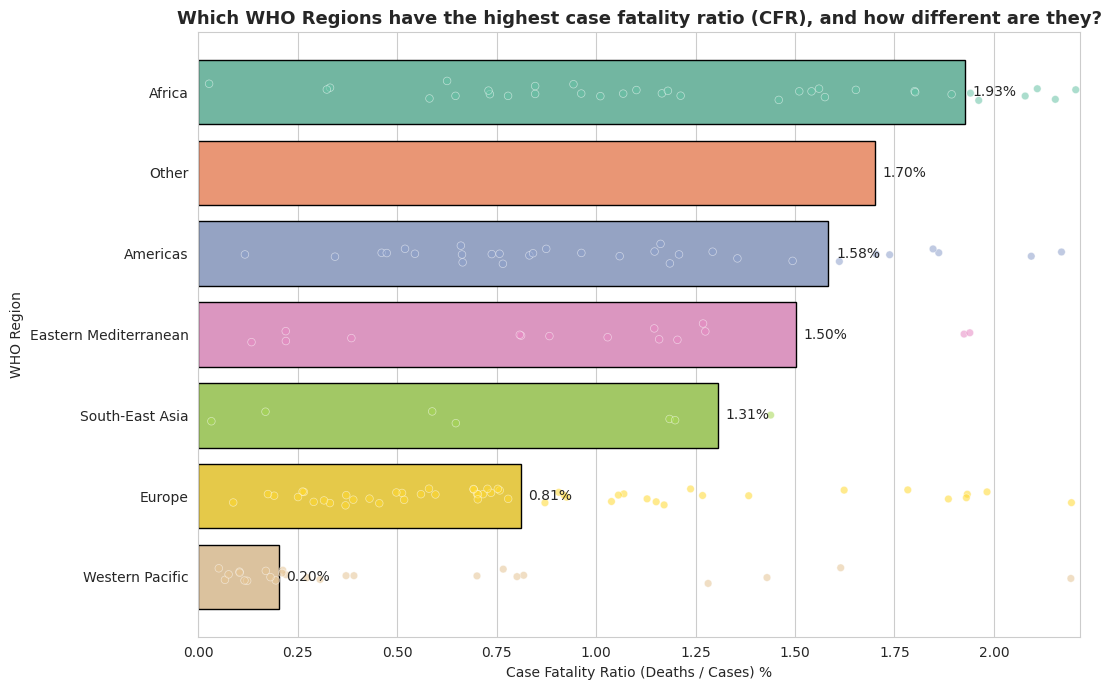

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load WHO data
df = pd.read_csv('WHO-COVID-19-global-table-data.csv')
df.columns = df.columns.str.strip()

# Select relevant columns and drop missing/zero values
df = df[['Name', 'WHO Region', 'Cases - cumulative total', 'Deaths - cumulative total']].dropna()
df = df[df['Cases - cumulative total'] > 0]

# Calculate country-level CFR (%)
df['CFR_country_pct'] = (df['Deaths - cumulative total'] / df['Cases - cumulative total']) * 100

# Optional: Filter out countries with very few cases/deaths to avoid unstable CFRs
df_filtered = df[(df['Deaths - cumulative total'] >= 10) & (df['Cases - cumulative total'] >= 10000)]

# Calculate region-level CFR (%), population-weighted
regional = (
    df.groupby('WHO Region', as_index=False)
      .agg({'Cases - cumulative total': 'sum', 'Deaths - cumulative total': 'sum'})
)
regional['CFR_region_pct'] = (regional['Deaths - cumulative total'] / regional['Cases - cumulative total']) * 100

# Sort regions by CFR
regional = regional.sort_values('CFR_region_pct', ascending=False)
region_order = regional['WHO Region'].tolist()

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(11, 7))
palette = sns.color_palette("Set2", n_colors=len(region_order))
region_to_color = {r: palette[i] for i, r in enumerate(region_order)}

# Bar plot for region-level CFR
bar = sns.barplot(
    data=regional,
    x='CFR_region_pct',
    y='WHO Region',
    order=region_order,
    palette=[region_to_color[r] for r in region_order],
    edgecolor='black'
)

# Overlay country-level CFRs (jittered vertically)
for i, region in enumerate(region_order):
    sub = df_filtered[df_filtered['WHO Region'] == region]
    if sub.empty:
        continue
    y_vals = np.random.normal(loc=i, scale=0.06, size=len(sub))
    plt.scatter(
        sub['CFR_country_pct'],
        y_vals,
        s=30,
        c=[region_to_color[region]] * len(sub),
        alpha=0.55,
        edgecolors='white',
        linewidths=0.5
    )

# Value labels on bars
for i, row in regional.iterrows():
    plt.text(
        row['CFR_region_pct'] + regional['CFR_region_pct'].max() * 0.01,
        region_order.index(row['WHO Region']),
        f"{row['CFR_region_pct']:.2f}%",
        va='center',
        fontsize=10
    )

plt.title("Which WHO Regions have the highest case fatality ratio (CFR), and how different are they?", fontsize=13, weight='bold')
plt.xlabel("Case Fatality Ratio (Deaths / Cases) %")
plt.ylabel("WHO Region")
plt.xlim(0, max(regional['CFR_region_pct']) * 1.15)
plt.tight_layout()
plt.show()


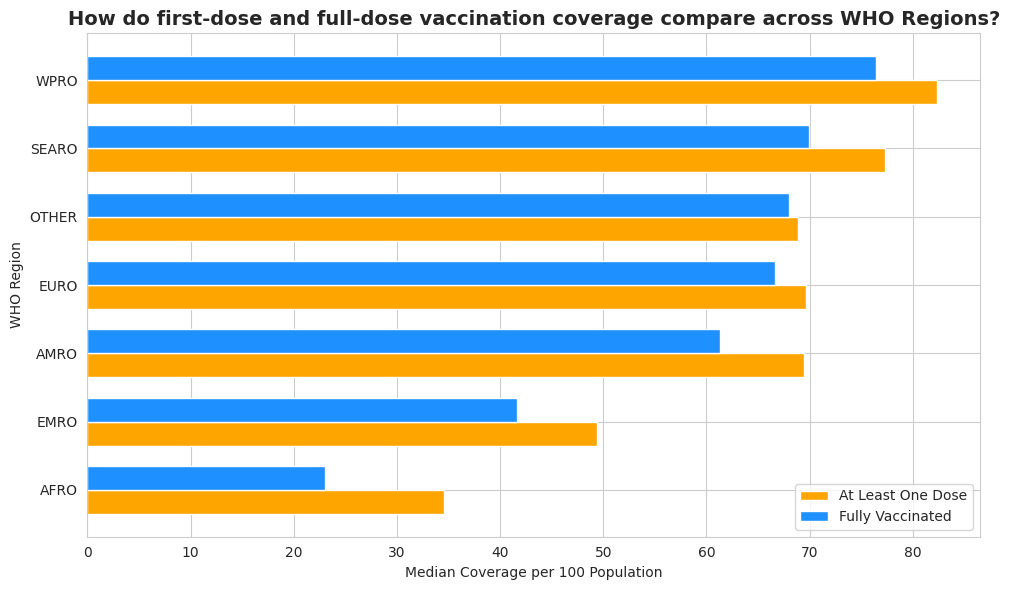

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
vax = pd.read_csv('Vaccination-data.csv')
vax.columns = vax.columns.str.strip()

# Select relevant columns and drop missing/invalid values
df = vax[['WHO_REGION', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100']].copy()
df = df.dropna(subset=['WHO_REGION', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100'])

# Group by WHO region and calculate median coverage
region_coverage = df.groupby('WHO_REGION').agg(
    median_first_dose=('PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'median'),
    median_full_dose=('PERSONS_FULLY_VACCINATED_PER100', 'median')
).reset_index()

# Sort regions by full-dose median for clarity
region_coverage = region_coverage.sort_values('median_full_dose', ascending=True)
y = range(len(region_coverage))
bar_height = 0.35

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.barh(
    [i - bar_height/2 for i in y],
    region_coverage['median_first_dose'],
    height=bar_height,
    color='orange',
    label='At Least One Dose'
)
plt.barh(
    [i + bar_height/2 for i in y],
    region_coverage['median_full_dose'],
    height=bar_height,
    color='dodgerblue',
    label='Fully Vaccinated'
)

plt.yticks(y, region_coverage['WHO_REGION'])
plt.title("How do first-dose and full-dose vaccination coverage compare across WHO Regions?", fontsize=14, weight='bold')
plt.xlabel("Median Coverage per 100 Population")
plt.ylabel("WHO Region")
plt.legend()
plt.tight_layout()
plt.show()


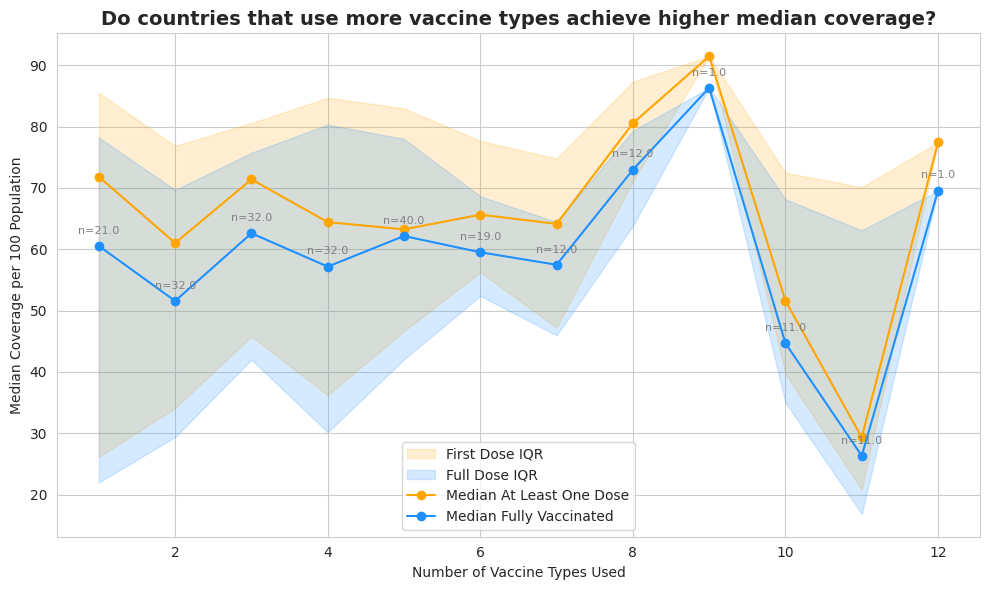

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load dataset
vax = pd.read_csv('Vaccination-data.csv')
vax.columns = vax.columns.str.strip()

# Select relevant columns and drop missing/invalid values
df = vax[['NUMBER_VACCINES_TYPES_USED', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100']].copy()
df = df.dropna(subset=['NUMBER_VACCINES_TYPES_USED', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100'])
df = df[df['NUMBER_VACCINES_TYPES_USED'] > 0]
df['NUMBER_VACCINES_TYPES_USED'] = df['NUMBER_VACCINES_TYPES_USED'].astype(int)

# Group by number of vaccine types and calculate median and IQR
def iqr(series):
    return np.percentile(series, 75) - np.percentile(series, 25)

coverage_by_types = df.groupby('NUMBER_VACCINES_TYPES_USED').agg(
    median_first_dose=('PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'median'),
    q1_first_dose=('PERSONS_VACCINATED_1PLUS_DOSE_PER100', lambda x: np.percentile(x, 25)),
    q3_first_dose=('PERSONS_VACCINATED_1PLUS_DOSE_PER100', lambda x: np.percentile(x, 75)),
    median_full_dose=('PERSONS_FULLY_VACCINATED_PER100', 'median'),
    q1_full_dose=('PERSONS_FULLY_VACCINATED_PER100', lambda x: np.percentile(x, 25)),
    q3_full_dose=('PERSONS_FULLY_VACCINATED_PER100', lambda x: np.percentile(x, 75)),
    count=('PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'size')
).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot IQR as shaded area for first dose
plt.fill_between(
    coverage_by_types['NUMBER_VACCINES_TYPES_USED'],
    coverage_by_types['q1_first_dose'],
    coverage_by_types['q3_first_dose'],
    color='orange', alpha=0.18, label='First Dose IQR'
)
# Plot IQR as shaded area for full dose
plt.fill_between(
    coverage_by_types['NUMBER_VACCINES_TYPES_USED'],
    coverage_by_types['q1_full_dose'],
    coverage_by_types['q3_full_dose'],
    color='dodgerblue', alpha=0.18, label='Full Dose IQR'
)

# Plot median lines
plt.plot(
    coverage_by_types['NUMBER_VACCINES_TYPES_USED'],
    coverage_by_types['median_first_dose'],
    marker='o', color='orange', label='Median At Least One Dose'
)
plt.plot(
    coverage_by_types['NUMBER_VACCINES_TYPES_USED'],
    coverage_by_types['median_full_dose'],
    marker='o', color='dodgerblue', label='Median Fully Vaccinated'
)

# Annotate sample size per group
for i, row in coverage_by_types.iterrows():
    plt.text(row['NUMBER_VACCINES_TYPES_USED'], row['median_full_dose'] + 2, f"n={row['count']}", ha='center', fontsize=8, color='gray')

plt.title("Do countries that use more vaccine types achieve higher median coverage?", fontsize=14, weight='bold')
plt.xlabel("Number of Vaccine Types Used")
plt.ylabel("Median Coverage per 100 Population")
plt.legend()
plt.tight_layout()
plt.show()


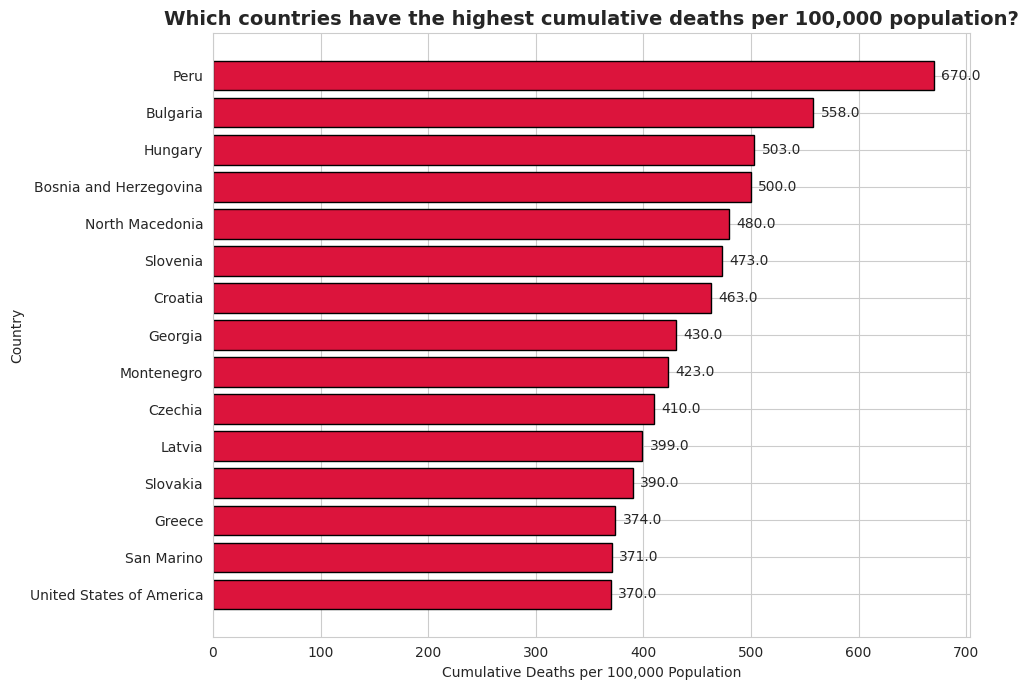

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('WHO-COVID-19-global-table-data.csv')
df.columns = df.columns.str.strip()

# Select relevant columns and drop missing/invalid values
df = df[['Name', 'Deaths - cumulative total per 100000 population']].copy()
df = df.dropna(subset=['Deaths - cumulative total per 100000 population'])
df = df[df['Deaths - cumulative total per 100000 population'] > 0]
df = df[df['Name'] != 'Global']  # Remove 'Global' row if present

# Get top 15 countries by deaths per 100k
top_n = 15
df_top = df.sort_values(by='Deaths - cumulative total per 100000 population', ascending=False).head(top_n)

# Sort for plotting (so the highest is at the top)
df_top = df_top.sort_values('Deaths - cumulative total per 100000 population', ascending=True)

# Plot
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
bars = plt.barh(
    df_top['Name'],
    df_top['Deaths - cumulative total per 100000 population'],
    color='crimson',
    edgecolor='black'
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(df_top['Deaths - cumulative total per 100000 population']) * 0.01,
             bar.get_y() + bar.get_height() / 2,
             f"{width:,.1f}",
             va='center', fontsize=10)

plt.title("Which countries have the highest cumulative deaths per 100,000 population?", fontsize=14, weight='bold')
plt.xlabel("Cumulative Deaths per 100,000 Population")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


/tmp/ipython-input-282556472.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_threshold = world['geometry'].area.median() * 0.1
/tmp/ipython-input-282556472.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  small_countries = merged[merged['geometry'].area < area_threshold]
/tmp/ipython-input-282556472.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  small_countries.geometry.centroid.plot(


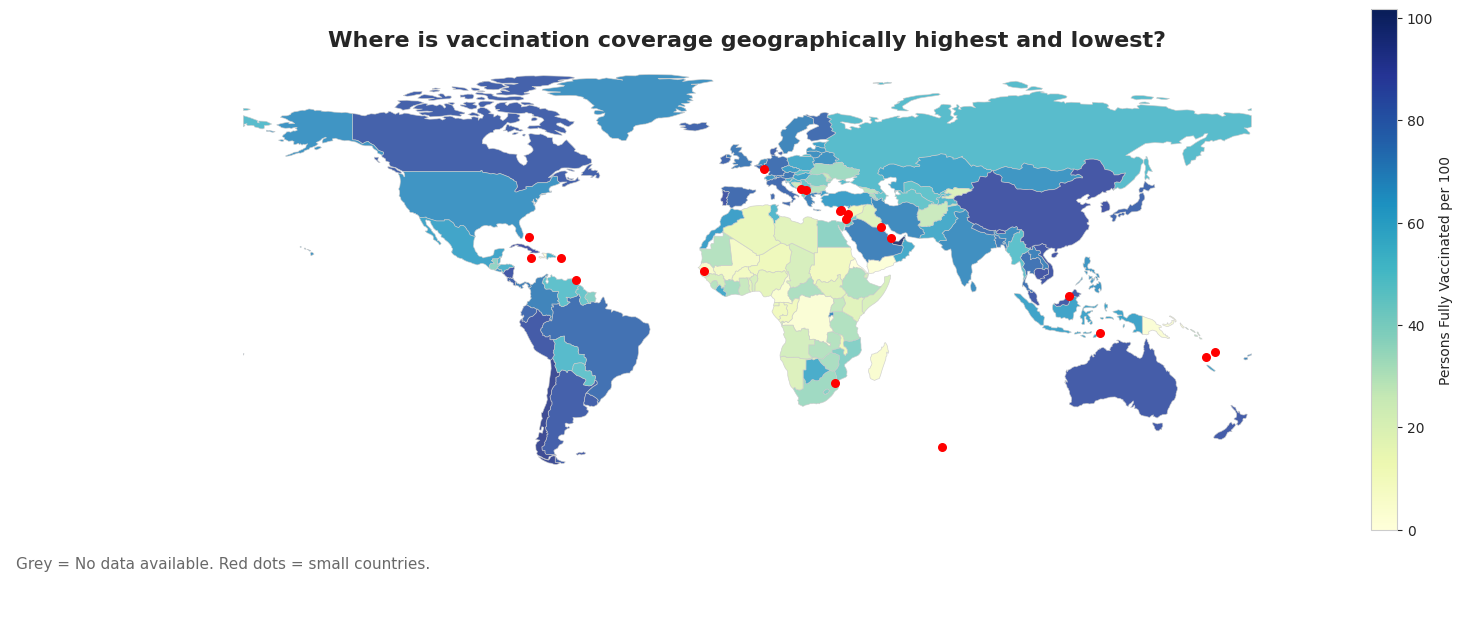

In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load vaccination data
vax = pd.read_csv('Vaccination-data.csv')
vax.columns = vax.columns.str.strip()

# Keep only relevant columns and drop missing/invalid values
df = vax[['ISO3', 'PERSONS_FULLY_VACCINATED_PER100']].copy()
df = df.dropna(subset=['ISO3', 'PERSONS_FULLY_VACCINATED_PER100'])
df = df[df['PERSONS_FULLY_VACCINATED_PER100'] >= 0]

# Load world map from GeoJSON (Natural Earth)
world = gpd.read_file(
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
)

# Merge vaccination data with world map using ISO_A3 instead of iso_a3
merged = world.merge(df, left_on='ISO_A3', right_on='ISO3', how='left')

# Identify small countries (area below a threshold, e.g., 0.1 median area)
area_threshold = world['geometry'].area.median() * 0.1
small_countries = merged[merged['geometry'].area < area_threshold]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
merged.plot(
    column='PERSONS_FULLY_VACCINATED_PER100',
    cmap='YlGnBu',
    linewidth=0.5,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Persons Fully Vaccinated per 100", 'shrink': 0.7},
    alpha=0.85  # Add transparency
)

# Overlay small country centroids as points
if not small_countries.empty:
    small_countries.geometry.centroid.plot(
        ax=ax,
        color='red',
        markersize=30,
        label='Small country (centroid)'
    )

# Title and remove axes
ax.set_title("Where is vaccination coverage geographically highest and lowest?", fontsize=16, weight='bold')
ax.set_axis_off()

# Add a note for countries with missing data
plt.annotate(
    "Grey = No data available. Red dots = small countries.",
    xy=(0.01, 0.08), xycoords='figure fraction',
    fontsize=11, color='dimgray'
)

plt.tight_layout()
plt.show()

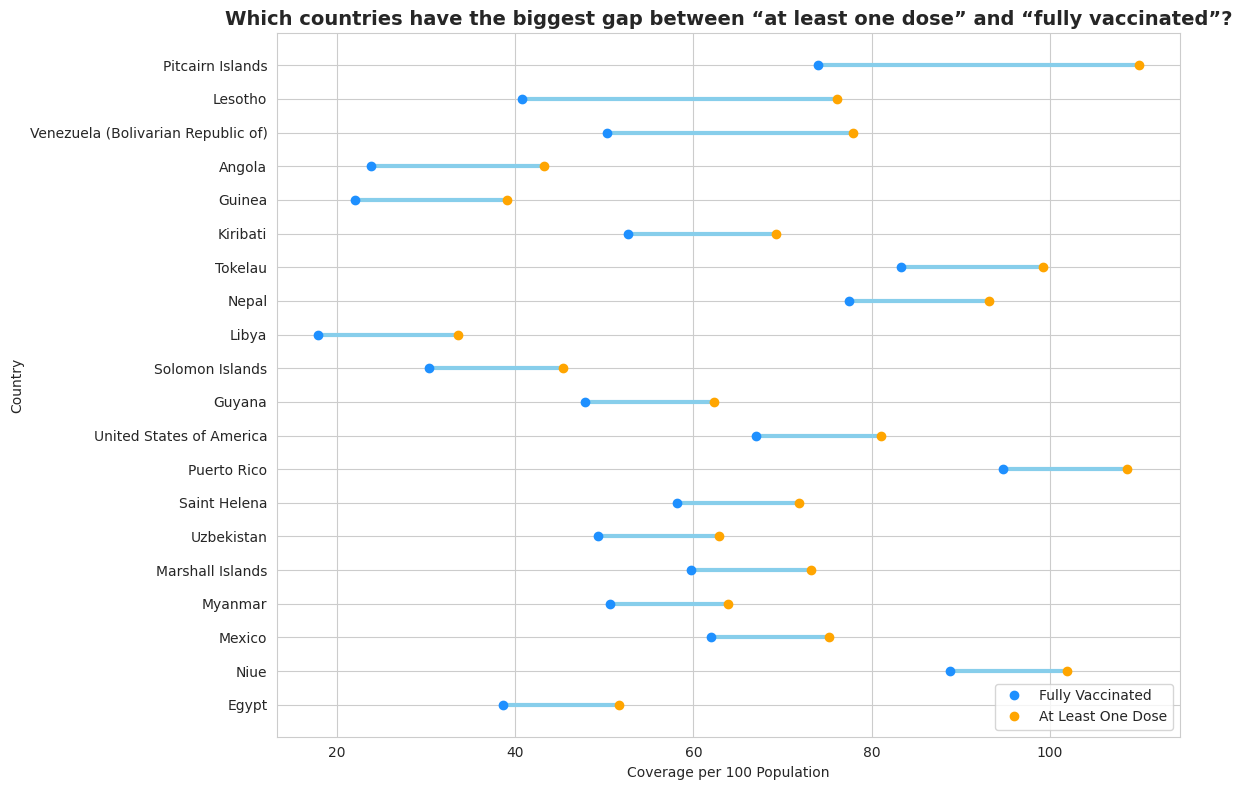

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load vaccination data
vax = pd.read_csv('Vaccination-data.csv')
vax.columns = vax.columns.str.strip()

# Select relevant columns and drop missing/invalid values
df = vax[['COUNTRY', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100']].copy()
df = df.dropna(subset=['PERSONS_VACCINATED_1PLUS_DOSE_PER100', 'PERSONS_FULLY_VACCINATED_PER100'])

# Calculate the gap
df['Gap_1dose_vs_full'] = df['PERSONS_VACCINATED_1PLUS_DOSE_PER100'] - df['PERSONS_FULLY_VACCINATED_PER100']

# Get top 20 countries by gap
top_gap = df.sort_values('Gap_1dose_vs_full', ascending=False).head(20)

# Sort for plotting
top_gap = top_gap.sort_values('Gap_1dose_vs_full', ascending=True)

# Plot lollipop chart
plt.figure(figsize=(12, 8))
plt.hlines(y=top_gap['COUNTRY'], xmin=top_gap['PERSONS_FULLY_VACCINATED_PER100'], xmax=top_gap['PERSONS_VACCINATED_1PLUS_DOSE_PER100'], color='skyblue', linewidth=3)
plt.plot(top_gap['PERSONS_FULLY_VACCINATED_PER100'], top_gap['COUNTRY'], 'o', color='dodgerblue', label='Fully Vaccinated')
plt.plot(top_gap['PERSONS_VACCINATED_1PLUS_DOSE_PER100'], top_gap['COUNTRY'], 'o', color='orange', label='At Least One Dose')

plt.title('Which countries have the biggest gap between “at least one dose” and “fully vaccinated”?', fontsize=14, weight='bold')
plt.xlabel('Coverage per 100 Population')
plt.ylabel('Country')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# **Install the required packed**

In [ ]:
# Load required libraries
library(treemap)
library(dplyr)
library(readr)
library(RColorBrewer)

# Read the data
df <- read_csv("WHO-COVID-19-global-table-data.csv")

# Clean and select relevant columns
df <- df %>%
  select(Country = Name, Region = `WHO Region`, Cases = `Cases - cumulative total`) %>%
  filter(!is.na(Cases) & Cases > 0)

# Aggregate to ensure no duplicates
df <- df %>%
  group_by(Region, Country) %>%
  summarise(Cases = sum(Cases), .groups = "drop")

# Treemap plot
palette <- brewer.pal(length(unique(df$Region)), "Set2")

treemap(
  df,
  index = c("Region", "Country"),
  vSize = "Cases",
  type = "index",
  palette = palette,
  title = "How do cumulative cases distribute by region and country contribution?",
  fontsize.title = 16,
  fontsize.labels = c(14, 9),
  border.col = c("white", "grey60"),
  border.lwds = c(3, 1),
  align.labels = list(
    c("center", "center"),  # Region
    c("left", "top")        # Country
  ),
  lowerbound.cex.labels = 0.5,
  inflate.labels = FALSE
)


In [ ]:
library(dplyr)
library(ggplot2)
library(tidyr)

# Read the data
df <- read.csv("Vaccination-data.csv", stringsAsFactors = FALSE)

# Clean and select relevant columns
df <- df %>%
  select(WHO_REGION,
         PERSONS_VACCINATED_1PLUS_DOSE_PER100,
         PERSONS_FULLY_VACCINATED_PER100) %>%
  filter(!is.na(WHO_REGION),
         !is.na(PERSONS_VACCINATED_1PLUS_DOSE_PER100),
         !is.na(PERSONS_FULLY_VACCINATED_PER100))

# Summarize by region (median is robust to outliers; use mean if you prefer)
region_summary <- df %>%
  group_by(WHO_REGION) %>%
  summarise(
    First_Dose = median(PERSONS_VACCINATED_1PLUS_DOSE_PER100, na.rm = TRUE),
    Full_Dose  = median(PERSONS_FULLY_VACCINATED_PER100, na.rm = TRUE)
  ) %>%
  ungroup()

# Prepare data for slopegraph
region_long <- region_summary %>%
  pivot_longer(
    cols = c(First_Dose, Full_Dose),
    names_to = "Dose_Type",
    values_to = "Coverage"
  )


# Order regions by Full_Dose for better readability
region_long$WHO_REGION <- factor(
  region_long$WHO_REGION,
  levels = region_summary$WHO_REGION[order(region_summary$Full_Dose)]
)

# Plot slopegraph
ggplot(region_long, aes(x = Dose_Type, y = Coverage, group = WHO_REGION, color = WHO_REGION)) +
  geom_line(size = 1.5, alpha = 0.8) +
  geom_point(size = 4) +
  geom_text(
    data = region_long %>% filter(Dose_Type == "Full_Dose"),
    aes(label = WHO_REGION),
    hjust = -0.1, size = 4
  ) +
  scale_x_discrete(labels = c("First_Dose" = "At least one dose", "Full_Dose" = "Fully vaccinated")) +
  labs(
    title = "How far are regions from complete coverage, and do they differ in first-dose vs full-dose balance?",
    x = "",
    y = "Coverage per 100 Population",
    color = "WHO Region"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 15),
    axis.text.x = element_text(face = "bold")
  ) +
  xlim("First_Dose", "Full_Dose") +
  ylim(0, max(region_long$Coverage, na.rm = TRUE) * 1.1)
